In [15]:
from propagation import fresnel_propagation
from propagation_LP import fresnel_propagation as fresnel_lp
from focal_spot_pattern import create_gaussian_mask

import numpy as np
import matplotlib.pyplot as plt
import LightPipes as lp
import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [16]:
# initial simulation settings
grid_dimension = 350
grid_size = 100e-5

gauss_width = 10e-5

wavelength = 2.75e-10
z = 1

dx = grid_size/grid_dimension

x = dx * np.arange(-int(grid_dimension/2), grid_dimension-int(grid_dimension/2))
y = dx * np.arange(-int(grid_dimension/2), grid_dimension-int(grid_dimension/2))
X, Y = np.meshgrid(x,y)

I0 = 1e6

In [18]:
print("Fresnel check...")
print(f"N_f = {np.pi*gauss_width**2/(wavelength*z)}\n")

print("Sampling conditions?")
fx = np.fft.fftshift(np.fft.fftfreq(grid_dimension, d=dx))
print(bool(fx[1]-fx[0] <= 1/(wavelength*z*2*np.max(np.abs(fx)))))

Fresnel check...
N_f = 114.23973285781067

Sampling conditions?
True


In [19]:
# computing theoretical waist value after propagation
def w(w0, lambda_, z):
    return w0 * np.sqrt(1 + (lambda_*z/(np.pi*w0*w0)))

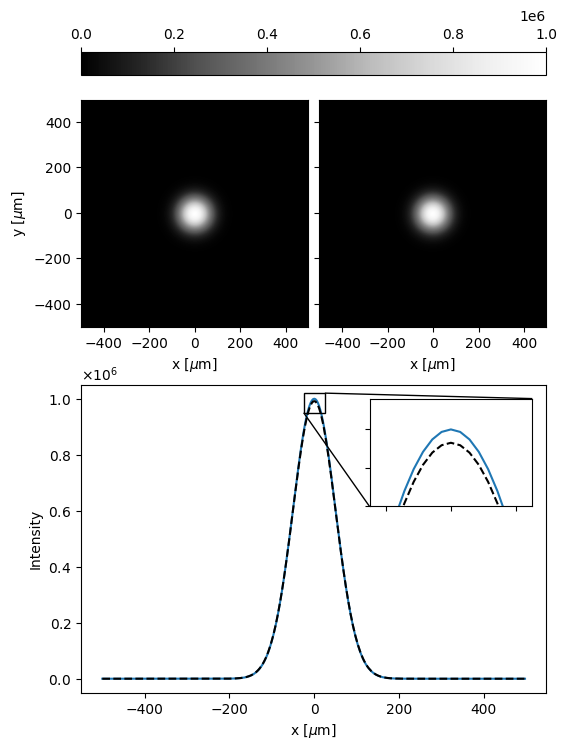

Tests for energy conservation...
START: 1924225500.323748
END: 1924225500.323748


In [20]:
# theoretical solutions
theoretical_start = I0 * np.exp(-2*(X**2+Y**2)/(gauss_width*gauss_width))
theoretical_prop = I0 * (gauss_width/w(gauss_width, wavelength, z))**2 * np.exp(-2*(X**2+Y**2)/(w(gauss_width, wavelength, z)**2))

fig = plt.figure(figsize=(6,9))

vmin = np.min([np.min(theoretical_start), np.min(theoretical_prop)])
vmax = np.max([np.max(theoretical_start), np.max(theoretical_prop)])

gs = gridspec.GridSpec(3,2)

ax1 = fig.add_subplot(gs[0:2,0])
im0 = ax1.imshow(theoretical_start, extent=(np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax1.set_ylabel("y [$\mu$m]")
ax1.set_xlabel("x [$\mu$m]")

ax2 = fig.add_subplot(gs[0:2,1])
im1 = ax2.imshow(theoretical_prop, extent=(np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax2.set_xlabel("x [$\mu$m]")
ax2.tick_params(labelleft=False)

im0.set_clim(vmin, vmax)
im1.set_clim(vmin, vmax)

fig.subplots_adjust(hspace=-0.375, wspace=0.05)
fig.colorbar(im0, ax=[ax1,ax2], location='top')

ax3 = fig.add_subplot(gs[2,:])
ax3.plot(x*1e6, theoretical_start[int(len(theoretical_start)/2)])
ax3.plot(x*1e6, theoretical_prop[int(len(theoretical_prop)/2)], color="black", linestyle="dashed")
ax3.set_xlabel("x [$\mu$m]")
ax3.set_ylabel("Intensity")
ax3.ticklabel_format(style="sci", axis='y', scilimits=(-3,2))
ax3.yaxis.major.formatter._useMathText = True

axins = inset_axes(ax3, width="35%", height="35%", loc='upper right', borderpad=1)
axins.plot(x*1e6, theoretical_start[int(len(theoretical_start)/2)])
axins.plot(x*1e6, theoretical_prop[int(len(theoretical_prop)/2)], '--', c="black")

axins.tick_params(labelleft=False,labelbottom=False)

# Set the x and y limits for the inset
x1, x2, y1, y2 = -25, 25, 0.95e6, 1.02e6  # Customize this to zoom into the area of interest
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

mark_inset(ax3, axins, loc1=3, loc2=1, fc="none", ec="0",zorder=10)

plt.show()

print("Tests for energy conservation...")
print(f"START: {np.sum(theoretical_start)}")
print(f"END: {np.sum(theoretical_prop)}")

[-175000. -174000. -173000. -172000. -171000. -170000. -169000. -168000.
 -167000. -166000. -165000. -164000. -163000. -162000. -161000. -160000.
 -159000. -158000. -157000. -156000. -155000. -154000. -153000. -152000.
 -151000. -150000. -149000. -148000. -147000. -146000. -145000. -144000.
 -143000. -142000. -141000. -140000. -139000. -138000. -137000. -136000.
 -135000. -134000. -133000. -132000. -131000. -130000. -129000. -128000.
 -127000. -126000. -125000. -124000. -123000. -122000. -121000. -120000.
 -119000. -118000. -117000. -116000. -115000. -114000. -113000. -112000.
 -111000. -110000. -109000. -108000. -107000. -106000. -105000. -104000.
 -103000. -102000. -101000. -100000.  -99000.  -98000.  -97000.  -96000.
  -95000.  -94000.  -93000.  -92000.  -91000.  -90000.  -89000.  -88000.
  -87000.  -86000.  -85000.  -84000.  -83000.  -82000.  -81000.  -80000.
  -79000.  -78000.  -77000.  -76000.  -75000.  -74000.  -73000.  -72000.
  -71000.  -70000.  -69000.  -68000.  -67000.  -660

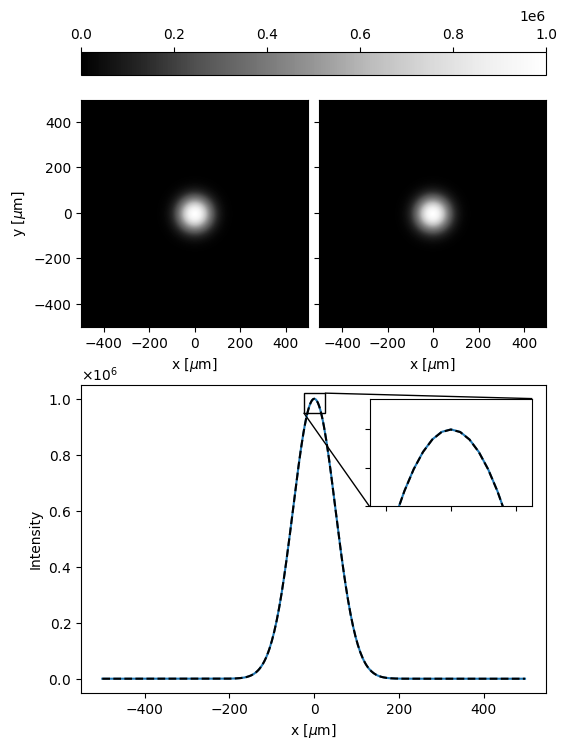

Tests for energy conservation...
START: 1924225500.323748
END: 1924225500.3237486


In [21]:
# custom code
E_in = np.sqrt(I0)*np.ones((grid_dimension, grid_dimension), dtype=np.complex128)
E_in *= create_gaussian_mask(X, Y, gauss_width)

E_out, start, end = fresnel_propagation(E_in, wavelength, z, dx)
E_out = E_out[start:end, start:end]

fig = plt.figure(figsize=(6,9))

vmin = np.min([np.min(np.abs(E_in)**2), np.min(np.abs(E_out)**2)])
vmax = np.max([np.max(np.abs(E_in)**2), np.max(np.abs(E_out)**2)])

gs = gridspec.GridSpec(3,2)

ax1 = fig.add_subplot(gs[0:2,0])
im0 = ax1.imshow(np.abs(E_in)**2, extent=(np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax1.set_ylabel("y [$\mu$m]")
ax1.set_xlabel("x [$\mu$m]")

ax2 = fig.add_subplot(gs[0:2,1])
im1 = ax2.imshow(np.abs(E_out)**2, extent=(np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax2.set_xlabel("x [$\mu$m]")
ax2.tick_params(labelleft=False)

im0.set_clim(vmin, vmax)
im1.set_clim(vmin, vmax)

fig.subplots_adjust(hspace=-0.375, wspace=0.05)
fig.colorbar(im0, ax=[ax1,ax2], location='top')

ax3 = fig.add_subplot(gs[2,:])
ax3.plot(x*1e6, np.abs(E_in[int(len(E_in)/2)])**2)
ax3.plot(x*1e6, np.abs(E_out[int(len(E_out)/2)])**2, color="black", linestyle="dashed")
ax3.set_xlabel("x [$\mu$m]")
ax3.set_ylabel("Intensity")
ax3.ticklabel_format(style="sci", axis='y', scilimits=(-3,2))
ax3.yaxis.major.formatter._useMathText = True
# ax3.axhline(y=1/(np.exp(1)**2)*I0)
# ax3.axvline(x=gauss_width)

axins = inset_axes(ax3, width="35%", height="35%", loc='upper right', borderpad=1)
axins.plot(x*1e6, np.abs(E_in[int(len(E_in)/2)])**2)
axins.plot(x*1e6, np.abs(E_out[int(len(E_out)/2)])**2, '--', c="black")

axins.tick_params(labelleft=False,labelbottom=False)

# Set the x and y limits for the inset
x1, x2, y1, y2 = -25, 25, 0.95e6, 1.02e6  # Customize this to zoom into the area of interest
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

mark_inset(ax3, axins, loc1=3, loc2=1, fc="none", ec="0",zorder=10)

plt.show()

print("Tests for energy conservation...")
print(f"START: {np.sum(np.abs(E_in)**2)}")
print(f"END: {np.sum(np.abs(E_out)**2)}")

E_out_copy = E_out.copy()

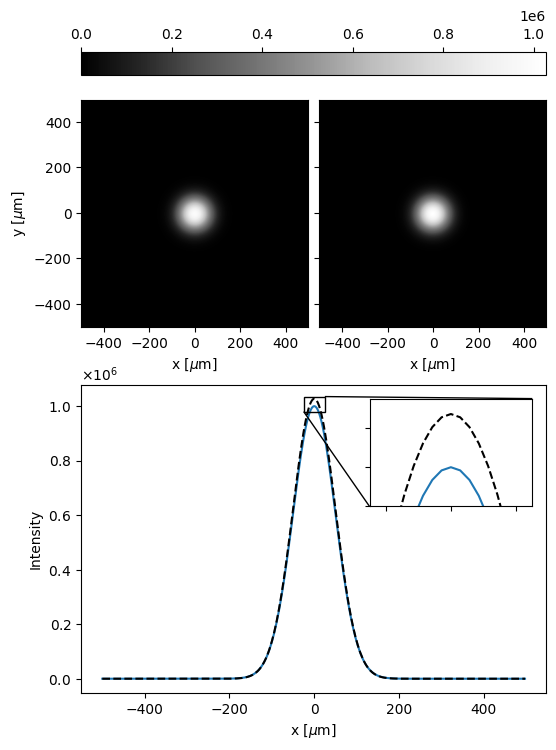

Tests for energy conservation...
START: 1924225500.323748
END: 1967820844.457711
1.0226560473949795


In [22]:
LP_in = lp.Begin(grid_size, wavelength, grid_dimension, dtype=np.complex128)
LP_in.field *= np.sqrt(I0)
LP_in = lp.GaussAperture(LP_in, 1/np.sqrt(2)*gauss_width)

LP_out = lp.Fresnel(LP_in, z)

fig = plt.figure(figsize=(6,9))

vmin = np.min([np.min(np.abs(LP_in.field)**2), np.min(np.abs(LP_out.field)**2)])
vmax = np.max([np.max(np.abs(LP_in.field)**2), np.max(np.abs(LP_out.field)**2)])

gs = gridspec.GridSpec(3,2)

ax1 = fig.add_subplot(gs[0:2,0])
im0 = ax1.imshow(np.abs(LP_in.field)**2, extent=(np.min(LP_in.xvalues)*1e6, np.max(LP_in.xvalues)*1e6, np.min(LP_in.xvalues)*1e6, np.max(LP_in.xvalues)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax1.set_ylabel("y [$\mu$m]")
ax1.set_xlabel("x [$\mu$m]")

ax2 = fig.add_subplot(gs[0:2,1])
im1 = ax2.imshow(np.abs(LP_out.field)**2, extent=(np.min(LP_in.xvalues)*1e6, np.max(LP_in.xvalues)*1e6, np.min(LP_in.xvalues)*1e6, np.max(LP_in.xvalues)*1e6), cmap="Greys_r", vmin=vmin, vmax=vmax)
ax2.set_xlabel("x [$\mu$m]")
ax2.tick_params(labelleft=False)

im0.set_clim(vmin, vmax)
im1.set_clim(vmin, vmax)

fig.subplots_adjust(hspace=-0.375, wspace=0.05)
fig.colorbar(im0, ax=[ax1,ax2], location='top')

ax3 = fig.add_subplot(gs[2,:])
ax3.plot(LP_in.xvalues*1e6, np.abs(LP_in.field[int(len(LP_in.field)/2)])**2)
ax3.plot(LP_in.xvalues*1e6, np.abs(LP_out.field[int(len(LP_out.field)/2)])**2, color="black", linestyle="dashed")
ax3.set_xlabel("x [$\mu$m]")
ax3.set_ylabel("Intensity")
ax3.ticklabel_format(style="sci", axis='y', scilimits=(-3,2))
ax3.yaxis.major.formatter._useMathText = True
# ax3.axhline(y=1/(np.exp(1)**2)*I0)
# ax3.axvline(x=gauss_width)

axins = inset_axes(ax3, width="35%", height="35%", loc='upper right', borderpad=1)
axins.plot(LP_in.xvalues*1e6, np.abs(LP_in.field[int(len(LP_in.field)/2)])**2)
axins.plot(LP_in.xvalues*1e6, np.abs(LP_out.field[int(len(LP_out.field)/2)])**2, '--', c="black")

axins.tick_params(labelleft=False,labelbottom=False)

# Set the x and y limits for the inset
x1, x2, y1, y2 = -25, 25, 0.98e6, 1.035e6  # Customize this to zoom into the area of interest
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

mark_inset(ax3, axins, loc1=3, loc2=1, fc="none", ec="0",zorder=10)

plt.show()

print("Tests for energy conservation...")
print(f"START: {np.sum(np.abs(LP_in.field)**2)}")
print(f"END: {np.sum(np.abs(LP_out.field)**2)}")
print(np.sum(np.abs(LP_out.field)**2)/np.sum(np.abs(LP_in.field)**2))

### Free space propagation gaussian beam

#### Uniform phase

In [130]:
E_in = np.sqrt(1e6) * np.ones((grid_dimension, grid_dimension), dtype=np.complex128)
E_in *= create_gaussian_mask(X, Y, gauss_width)

In [131]:
E_out, start, end = fresnel_propagation(E_in, wavelength, z, grid_size/grid_dimension)

In [132]:
print("Computing Fresnel number...")
print(f"N_F = {gauss_width**2/(wavelength*z)}\n")

print("SAMPLING CONDITIONS\nDelta_x in the propagated plane should be higher than:")
print(wavelength*z/grid_size)

Computing Fresnel number...
N_F = 36.36363636363637

SAMPLING CONDITIONS
Delta_x in the propagated plane should be higher than:
2.7499999999999996e-07


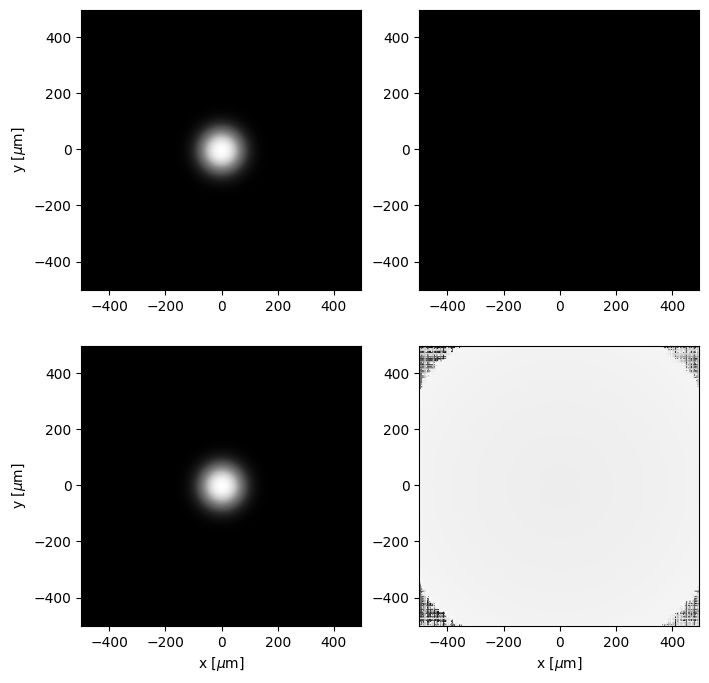

In [133]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8,8))

min_scale = np.min([np.min(np.abs(E_in)**2), np.min(np.abs(E_out)**2)])
max_scale = np.max([np.max(np.abs(E_in)**2), np.max(np.abs(E_out)**2)])

im1 = ax[0][0].imshow(np.abs(E_in)**2, vmin=min_scale, vmax=max_scale, extent=[np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6], cmap="Greys_r")
ax[0][0].set_ylabel('y [$\mu$m]')

ax[0][1].imshow(np.angle(E_in), extent=[np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6], cmap="Greys_r")

im2 = ax[1][0].imshow(np.abs(E_out)**2, vmin=min_scale, vmax=max_scale, extent=[np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6], cmap="Greys_r")
ax[1][0].set_ylabel('y [$\mu$m]')
ax[1][0].set_xlabel('x [$\mu$m]')

ax[1][1].imshow(np.angle(E_out), extent=[np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6], cmap="Greys_r")
ax[1][1].set_xlabel('x [$\mu$m]')

im1.set_clim(min_scale, max_scale)
im2.set_clim(min_scale, max_scale)

In [141]:
E_in_LP = lp.Begin(grid_size, wavelength, grid_dimension, dtype=np.complex128)
E_in_LP.field *= np.sqrt(1e6)

In [142]:
E_in_LP = lp.GaussAperture(E_in_LP, gauss_width)
E_out_LP = lp.Fresnel(E_in_LP, z)

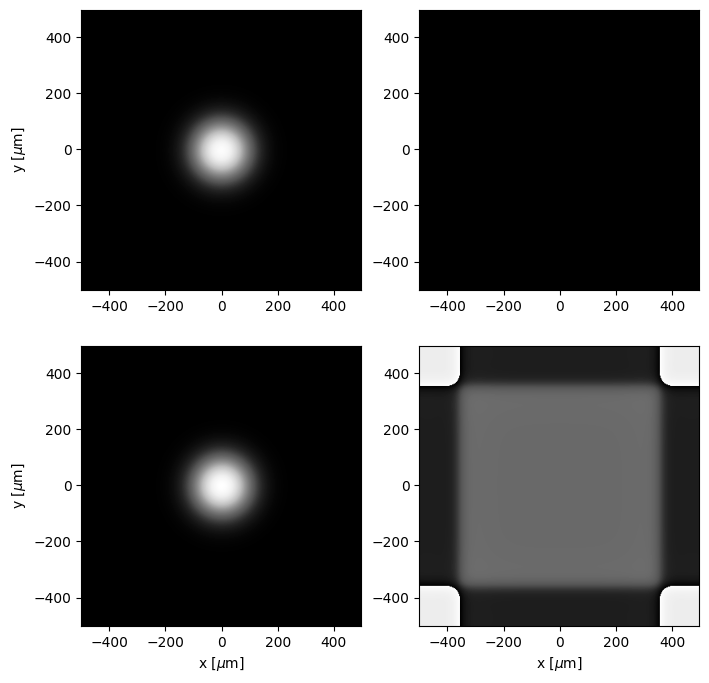

In [143]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8,8))

min_scale = np.min([np.min(np.abs(E_in_LP.field)**2), np.min(np.abs(E_out_LP.field)**2)])
max_scale = np.max([np.max(np.abs(E_in_LP.field)**2), np.max(np.abs(E_out_LP.field)**2)])

im1 = ax[0][0].imshow(np.abs(E_in_LP.field)**2, vmin=min_scale, vmax=max_scale, extent=[np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6], cmap="Greys_r")
ax[0][0].set_ylabel('y [$\mu$m]')

ax[0][1].imshow(np.angle(E_in_LP.field), extent=[np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6], cmap="Greys_r")

im2 = ax[1][0].imshow(np.abs(E_out_LP.field)**2, vmin=min_scale, vmax=max_scale, extent=[np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6], cmap="Greys_r")
ax[1][0].set_ylabel('y [$\mu$m]')
ax[1][0].set_xlabel('x [$\mu$m]')

ax[1][1].imshow(np.angle(E_out_LP.field), extent=[np.min(x)*1e6, np.max(x)*1e6, np.min(y)*1e6, np.max(y)*1e6], cmap="Greys_r")
ax[1][1].set_xlabel('x [$\mu$m]')

im1.set_clim(min_scale, max_scale)
im2.set_clim(min_scale, max_scale)

In [144]:
def w(w0, lambda_, z):
    return w0 * np.sqrt(1 + (lambda_*z/(np.pi*w0*w0))**2)

In [145]:
solution = np.sqrt(1e6)*create_gaussian_mask(X, Y, w(gauss_width, wavelength, z))

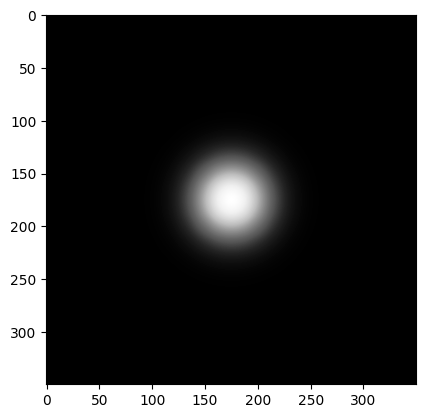

In [146]:
plt.figure()
plt.imshow(solution, cmap="Greys_r")

[[-1.81362049e-27 -1.07891298e-27 -1.32160172e-27 ... -2.16584363e-27
  -5.55120174e-27 -2.97939162e-27]
 [-4.05699669e-27 -2.96626179e-27 -3.08634781e-27 ... -4.21036797e-27
  -9.00218881e-27 -5.86399270e-27]
 [-8.55652224e-28 -9.59956300e-28 -4.26992156e-28 ... -1.85140282e-28
  -4.27463566e-28 -5.85805940e-28]
 ...
 [-1.15655246e-27 -6.84562114e-28 -1.46208943e-28 ... -4.22464871e-28
  -2.78840810e-27 -1.75862492e-27]
 [-3.66050404e-28 -1.17996976e-28 -1.45249669e-28 ... -2.74747178e-28
  -1.96003926e-27 -7.51845828e-28]
 [-1.22536629e-27 -6.28021466e-28 -6.45948992e-28 ... -1.12223371e-27
  -4.02857623e-27 -2.16876370e-27]]
[[-0.00044307 -0.00043952 -0.00043526 ... -0.00043026 -0.00043521
  -0.00043944]
 [-0.00043952 -0.00043601 -0.00043178 ... -0.00042682 -0.00043173
  -0.00043593]
 [-0.00043526 -0.00043178 -0.00042759 ... -0.00042268 -0.00042754
  -0.0004317 ]
 ...
 [-0.00043026 -0.00042682 -0.00042268 ... -0.00041783 -0.00042263
  -0.00042674]
 [-0.00043521 -0.00043173 -0.000427

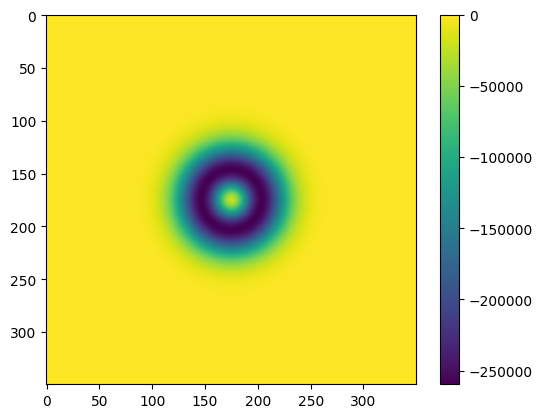

In [149]:
print(np.abs(solution)**2 - np.abs(E_out)**2)
print(np.abs(solution)**2 - np.abs(E_out_LP.field)**2)

plt.imshow(np.abs(solution)**2-np.abs(E_out)**2)
plt.imshow(np.abs(solution)**2-np.abs(E_out_LP.field)**2)
plt.colorbar()

### dump

In [3]:
E_in = np.ones((grid_dimension, grid_dimension), dtype=np.complex128)

In [4]:
random_phase = np.exp(1j * np.random.uniform(1, 2*np.pi, (grid_dimension, grid_dimension)))
E_in *= random_phase

In [5]:
E_in *= create_gaussian_mask(X, Y, diameter=gauss_width)

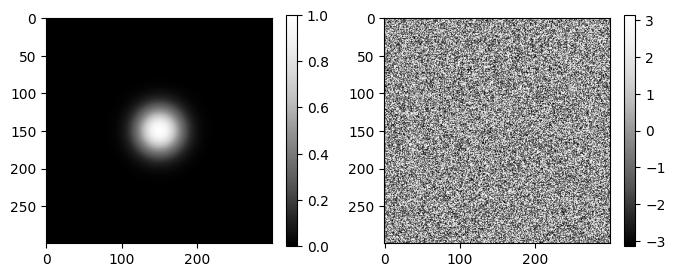

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4))

im1 = ax[0].imshow(np.abs(E_in)**2, cmap='Greys_r')
im2 = ax[1].imshow(np.angle(E_in), cmap='Greys_r')

fig.colorbar(im1, ax=ax[0], shrink=0.75)
fig.colorbar(im2, ax=ax[1], shrink=0.75)

plt.show()

In [7]:
### CHECKPOINT NYQUIST AND FRESNEL/FRAUNHOFER
print(wavelength*z <= (grid_size*grid_size)/grid_dimension)

if wavelength*z > (grid_size*grid_size)/grid_dimension:
    print(wavelength*z)
    print((grid_size*grid_size)/grid_dimension)

nF = grid_size**2/(wavelength*z)

if nF >= 1:
    print("Fresnel!")
else:
    print("Fraunhofer")

True
Fresnel!


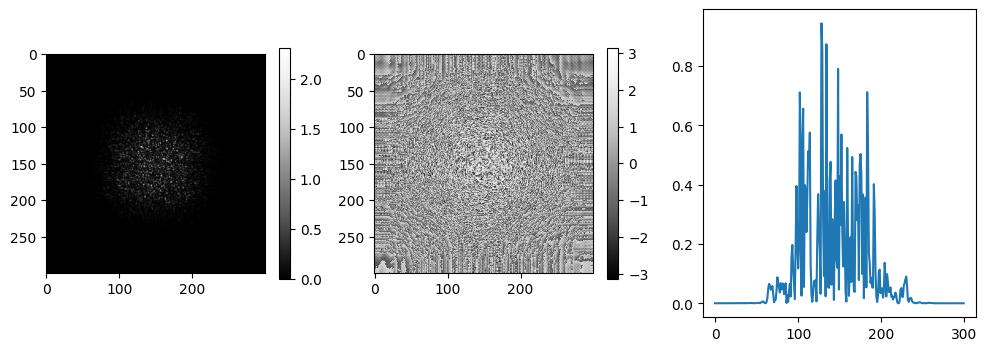

In [8]:
#using our code
E_out, start, end = fresnel_propagation(E_in, wavelength, z, grid_size/grid_dimension, padding_factor=10)

fig, ax = plt.subplots(ncols=3, figsize=(12,4))

im1 = ax[0].imshow(np.abs(E_out[start:end, start:end])**2, cmap='Greys_r')
im2 = ax[1].imshow(np.angle(E_out[start:end, start:end]), cmap='Greys_r')
im3 = ax[2].plot(np.abs(E_out[int(len(E_out)/2)][start:end])**2)

fig.colorbar(im1, ax=ax[0], shrink=0.75)
fig.colorbar(im2, ax=ax[1], shrink=0.75)

plt.show()

In [9]:
from propagation_LP import fresnel_propagation

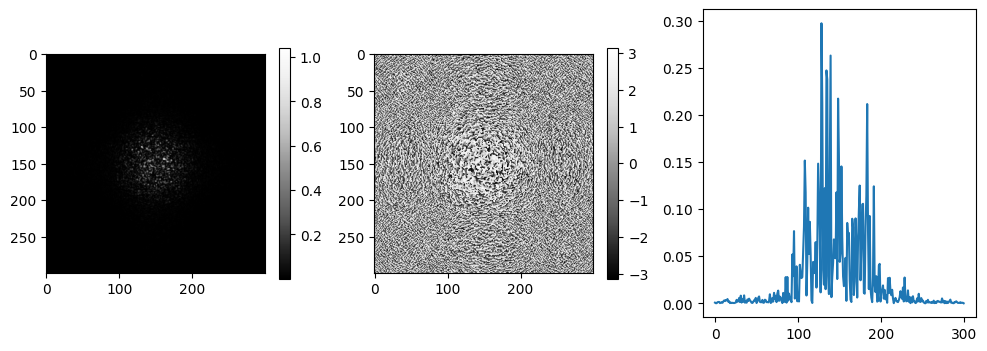

In [10]:
#using our code
E_out = fresnel_propagation(E_in, wavelength, z, grid_size/grid_dimension)

fig, ax = plt.subplots(ncols=3, figsize=(12,4))

im1 = ax[0].imshow(np.abs(E_out)**2, cmap='Greys_r')
im2 = ax[1].imshow(np.angle(E_out), cmap='Greys_r')
im3 = ax[2].plot(np.abs(E_out[int(len(E_out)/2)])**2)

fig.colorbar(im1, ax=ax[0], shrink=0.75)
fig.colorbar(im2, ax=ax[1], shrink=0.75)

plt.show()

In [11]:
#using lightpipes
from LightPipes import Begin, GaussAperture, Fresnel

E_in = Begin(grid_size, wavelength, grid_dimension)
E_in = GaussAperture(E_in, gauss_width/2)
E_in.field *= random_phase

E_out = Fresnel(E_in, z)

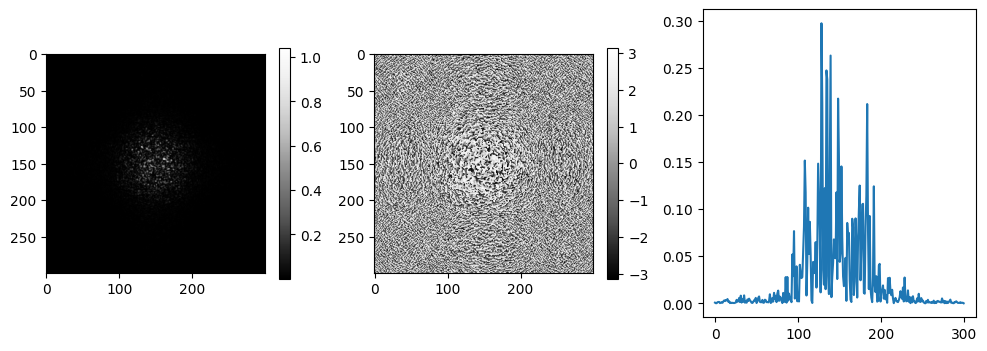

In [12]:
#using our code
fig, ax = plt.subplots(ncols=3, figsize=(12,4))

im1 = ax[0].imshow(np.abs(E_out.field)**2, cmap='Greys_r')
im2 = ax[1].imshow(np.angle(E_out.field), cmap='Greys_r')
im3 = ax[2].plot(np.abs(E_out.field[int(len(E_out.field)/2)])**2)

fig.colorbar(im1, ax=ax[0], shrink=0.75)
fig.colorbar(im2, ax=ax[1], shrink=0.75)

plt.show()